In [1]:
import math
import numpy as np
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt

In [ ]:
def f(x,y):
    return 418.9829*2 - x*np.sin(np.sqrt(abs(x))) - y*np.sin(np.sqrt(abs(y)))

# Implementar

### Log

In [2]:
def log_results(filename, poblacion_final):
    poblacion_final = poblacion_final.sort_values('apt')
    # Guardar población
    poblacion_final.to_csv(f'log/poblaciones/pop_{filename}.csv')

    # Estadísticos
    sol_min = poblacion_final.iloc[0]
    sol_max = poblacion_final.iloc[-1]
    apt_media = poblacion_final['apt'].mean()
    apt_std = poblacion_final['apt'].std()

    pop_stats = pd.Series({'min_crom': sol_min['cromosoma'], 'min_apt': sol_min['apt'],
                           'max_crom': sol_max['cromosoma'], 'max_apt': sol_max['apt'],
                           'media_apt': apt_media, 'std_apt': apt_std})
    pop_stats.to_csv(f'log/estadisticas/stats_{filename}.csv')


In [3]:
def parent_df(fathers, mothers):
    '''
    Crea un DataFrame agrupando los individuos en Padres y Madres.
    '''
    fathers = fathers.reset_index()
    mothers = mothers.reset_index()
    col_groups = pd.MultiIndex.from_arrays([['Padres']*3 + ['Madres']*3, fathers.columns.tolist() + mothers.columns.tolist()])

    # Concatenar los DataFrames horizontalmente
    padres_df = pd.concat([fathers, mothers], axis=1)
    padres_df.columns = col_groups
    return padres_df


In [131]:
def log_generacion(filename, mode='save', **kwargs):
    if mode=='save':
        # gener_elements = {'Poblacion', 'Nueva poblacion', 'Padres': parent_df, 'Hijos', 'Puntos cruza', 'Valores de mutacion', 'Mejor individuo'}
        # df(N,2), df(N,2), tuple (N//2,2), [df(N), Series(N//2), Series(N)], dataframe(1,2)
        # Convertir padres a dataframe agrupado por columnas
        # Unir Hijos | Puntos cruza | Valores de mutacion
        # Crear un Dataframe con todo eso
        # Pasar todo a to_string()
        # Guardar to csv

        # Padres
        kwargs['Padres'] = parent_df(*kwargs['Padres'])

        # Hijos
        hijos = kwargs.pop('Hijos')
        hijos = hijos.reshape(2,hijos.shape[0]//2) # Forma de hermanos
        hijos_df = pd.DataFrame(hijos).T

        # Puntos cruza, info de padres y valores de mutación
        puntos_cruza = kwargs.pop('Puntos cruza')
        val_mut = kwargs.pop('Valores de mutacion')
        val_mut = val_mut.reshape(2, val_mut.shape[0]//2).T # Forma de hermanos

        kwargs['Hijos'] = hijos_df.assign(**{'Punto cruza':puntos_cruza,
                                           'P':kwargs['Padres']['Padres']['index'].values, 'M':kwargs['Padres']['Madres']['index'].values,
                                           'Valores mutación 0':val_mut[:,0], 'Valores mutación 1':val_mut[:,1]})
        
        # Convertir a texto para su impresión y guardar
        pd.Series(kwargs).apply(lambda df: df.to_string()).to_csv(f'log/generaciones/gen_text_{str(filename)}.csv')
        # Guardar nueva población
        kwargs['Nueva poblacion'].to_csv(f'log/generaciones/gen_pop_{str(filename)}.csv')
        pass

    elif mode=='load':
        return pd.read_csv(f'log/generaciones/{str(filename)}.csv',**kwargs)


### Estructura cromosómica

In [5]:
class Gen:
    """
    Clase que representa la estructura y funcionamiento de un gen. No representa a un Gen.

    ...

    Attributes
    ----------
    dominio : tuple
        Dominio de valores reales del gen [x,y]
    precision : int
        Número de decimales que puede adquirir el valor real del Gen.
    len : int
        Longitud del Gen en su expresión binaria.
    norm : Decimal
        Constante de normalización del rango de valores binarios posibles del Gen al Dominio de sus valores reales.
    offset : Decimal
        Desplazamiento del Dominio expresado en valores enteros (sin punto decimal) a la región > 0.

    Methods
    -------
    translate(x,mode='decode')
        Traduce entre representación binaria de un Gen <-> expresión real
    """

    def __init__(self,dominio,precision):
        """
        Parameters
        ----------
        dominio : tuple
            Límites (liminf, limsup) de la variable en cuestión.
        precision : int
            Número de cifras decimales luego del punto para la variable en cuestión. Debe ser mayor al máximo número de decimales en el dominio
        """       
        self.dominio = dominio
        self.precision = precision
        self.len = self._length()

        # Offset lb -> all(0) ; ub -> all(1)
        self.norm = (Decimal(str(dominio[1])) - Decimal(str(dominio[0]))) *10**precision / int('1'*self.len,2)
        self.offset = Decimal(str(dominio[0])) #* 10**precision

    
    def _length(self):
        """Calcula el número de bits en un gen.

        Returns
        -------
        int
            Número de bits del gen <-> variable.
        """
        # Limites
        rango = self.dominio[1] - self.dominio[0]
        cell_count = math.ceil(np.log2(rango))

        # Decimales
        cell_count += math.ceil(np.log2(10**self.precision - 1))
        return cell_count
    
    def translate(self,x,mode='decode'):
        '''
        Traductor para codificar/decodificar (reales <-> binario) genes. 

        Parameters
        ----------
        x : float or str
            Gen a traducir (float si es un real, str si es binario).
        mode : str (code,decode)
            Uno de dos modos: 'code' para pasar de número real a binario, y 'decode' para pasar de binario a real.

        Returns
        -------
        str or float
            Gen traducido (str si x era un float, float si x era binario).
        '''
        
        if mode == 'code':
            ## Real -> Binario
            
            # Cortar decimales por redondeo
            x = float(x) # failsafe
            x = round(x,self.precision) - self.offset # precision y offset

            # Eliminar punto
            x_int,x_dec = str(x).split(".")
            x_dec = x_dec.ljust(self.precision,"0") # Rellena decimales de precision

            # Representación entera
            x_rep = int(x_int + x_dec)

            # Offset -> ran >= 0
            x_rep = Decimal(str(x_rep)) / self.norm
            x_rep = round(x_rep) # Nuevos decimales son de orden mayor a la precision
            return np.binary_repr(x_rep, width=self.len)
        
        elif mode == 'decode':
            ## Binario -> Real

            # Convierte a entero base 10
            x_rep = int(x,2)

            # Extraer Normalización
            x_rep = round(x_rep * self.norm)  # Nuevos decimales son de orden mayor a la precision + self.offset
            
            # Añadir el punto decimal
            x_rep = str(x_rep).zfill(self.precision) # Rellena decimales de precision
            int_part = x_rep[:-self.precision]
            dec_part = x_rep[-self.precision:]
            x_float = Decimal(int_part + '.' + dec_part)
            
            # Regresar offset
            x_float = x_float + self.offset 
            return float(x_float)

In [8]:
class Cromosoma:
    """
    Clase que representa la estructura y funcionamiento de un Cromosoma. No representa a un Cromosoma.

    ...

    Attributes
    ----------
    genes : tuple
        Tupla de objetos Gen en el Cromosoma, ordenados según el locus del gen.
    cromosoma : str
        Expresión binaria del cromosoma (genotipo). Es calculada sólo mediante el método "genotipo".
    crom_len : int
        Longitud del Cromosoma en su expresión binaria.

    Methods
    -------
    genotipo(x,mode='decode')
        Traduce entre representación binaria de un Cromosoma <-> expresión real de sus Genes.
    """

    def __init__(self,*genes):
        """
        Parameters
        ----------
        genes : Gen
            Gen(es) del cromosoma ordenado(s)
        """       
        
        self.genes = genes
        self.cromosoma = None
        self.crom_len = sum([gen.len for gen in genes])
        
    def genotipo(self,x,mode='decode'):
        '''
        Traductor para codificar/decodificar (reales <-> binario) cromosomas a través de sus genes.

        Parameters
        ----------
        x : list o str
            Expresión del cromosoma (lista si los genes se expresan en números reales, str si el cromosoma es binario)
        mode : str (code,decode)
            Uno de dos modos: 'code' para pasar de número real a binario, y 'decode' para pasar de binario a real.

        Returns
        -------
        str o list
            Cromosoma traducido (elementos tipo str si "genes" era una lista, lista si "genes" era binario).
        '''

        if mode == 'code':
            ## Real -> Binario
            genes_bin = [gen.translate(val, mode=mode) for val,gen in zip(x,self.genes)]
            self.cromosoma = ''.join(genes_bin)
            return self.cromosoma
        
        elif mode == 'decode':
            ## Binario -> Real
            genes_lens = [gen.len for gen in self.genes]
            ind_final = np.cumsum(genes_lens)
            genes_r = [gen.translate(x[ind-lens:ind]) for gen, lens, ind in zip(self.genes, genes_lens, ind_final)]
            return genes_r

### Algoritmo

In [152]:
class SimpleEvolutionary(Cromosoma):
    """
    Clase del Algoritmo Evolutivo Simple que hereda una estructura Cromosoma para funcionar.

    ...
    Methods
    -------
    genotipo(x,mode='decode')
        Traduce entre representación binaria de un Cromosoma <-> expresión real de sus Genes.
    """

    def optimize(self,f,N,num_gener,fast=False,verbose=True,export_name='None',gen_log=False):
        '''
        Rutina de maximización de una función "f". Imprimime la información de cada generación.

        Parameters
        ----------
        f : function
            Función a maximizar
        N : int
            Número de individuos en la población inicial.
        num_gener : int
            Número de generaciones esperadas.
        fast : bool, optional
            Trunca el algoritmo cuando el mejor individuo de la generación anterior es igual al mejor individuo 
            de la generación actual (default=False)
        verbose : bool, optional
            Imprime información de los individuos y procesos de cada generación. (default=True)
        export_name : str, optional
            Nombre del archivo de registro de finalización del algoritmo. (default='None')
        gen_log : bool, optional
            Guarda información de la generación en un archivo (default=False)

        Returns
        -------
        Series
            Mejor individuo (cromosoma binario, aptitud) al cumplirse los criterios de la rutina.
        '''
        #%#%#%#%#% Inicializar
        self.f = f
        self.N = N
        self.mejor_individuo = None
        # Sólo poblaciones pares
        if N % 2 != 0: 
            self.N = N + 1
        # Genera población aleatoria
        self.poblacion = self.random_generator(self.N,self.crom_len)

        #%#%#%#%#% Rutina evolutiva
        for generacion in range(num_gener):
            # Selecciona padres
            par_selection = self.ruleta()
            # Cruza los padres 2 a 2
            mothers = par_selection.iloc[1::2]
            fathers = par_selection.iloc[::2]
            
            # Generación de hijos
            recombinacion = np.array(np.vectorize(self.cruza)
                                     (fathers['cromosoma'], mothers['cromosoma'])
                                     )
            cruza = recombinacion[[0,1],:].reshape(-1)
            puntos_cruza = recombinacion[-1,:]
            n_muts, mutacion, flips = np.vectorize(self.mutacion)(cruza)
            
            # Aptitud de hijos
            descendencia = pd.DataFrame([self.individuo(cromosoma) for cromosoma in mutacion],
                                        columns = ['cromosoma','apt'])
            # Elitismo
            nueva_poblacion = self.sobrevivientes(descendencia)
            self.mejor_individuo = nueva_poblacion.iloc[np.argmax(nueva_poblacion['apt'])]
            
            if gen_log:
                kwargs = {'Poblacion':self.poblacion, 'Nueva poblacion':nueva_poblacion, 'Mejor individuo':self.mejor_individuo,
                          'Padres':(fathers, mothers), 'Hijos':mutacion,
                          'Puntos cruza':puntos_cruza, 'Valores de mutacion':flips}
                log_generacion(export_name+'_'+str(generacion), mode='save', **kwargs)

            # Actualizar población
            self.poblacion = nueva_poblacion

            # Imprimir descripción de la generación
            if verbose:
                self._gen_descripcion(generacion, mothers, n_muts)
            if fast and (self.mejor_individuo['apt'] == self.poblacion['apt'].iloc[0]):
                break
                
        log_results(filename=export_name, poblacion_final=self.poblacion)
        print(f'~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n','Mejor individuo:')
        print(self.mejor_individuo.to_dict())
        return self.mejor_individuo.to_dict()
    

    def _gen_descripcion(self,gener,cruzas,n_muts):
        '''
        Imprime la información de una generación
        '''
    
        apt_stats = f'''
        ##### Aptitud nominal #####
        Máximo: {self.poblacion['apt'].max()} | Media: {self.poblacion['apt'].mean()} | Mínimo: {self.poblacion['apt'].min()}
        '''
        #:.4f

        recombining_stats = f'''
        ##### Recombinación #####
        Cruzas: {len(cruzas)} | Mutaciones: {sum(n_muts)}
        '''

        best_cr = self.mejor_individuo['cromosoma']
        best_individual = f'''
        ##### Mejor individuo #####
        Genotipo: {best_cr} | Fenotipo: {self.genotipo(best_cr)} | Aptitud: {self.mejor_individuo['apt']}
        '''

        print(f'Generación {gener+1} ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%\n', apt_stats, recombining_stats, best_individual)



    ##############################
    #### GENERACIÓN ALEATORIA ####
    def individuo(self,cromosoma):
        '''
        Genera un individuo (cromosoma,aptitud) a partir de su cromosoma.
        '''
        return cromosoma, self.f(*self.genotipo(cromosoma))
    
    def random_generator(self,N,size):
        '''
        Rutina de generación aleatoria de individuos

        Parameters
        ----------
        N : int
            Número de individuos en la población.
        size : int
            Longitud del cromosoma característico de los individuos en la población.

        Returns
        -------
        array
            Individuos generados como un array de cromosomas (col0) con su aptitud (col1) respectiva.
        '''
        # Creación de población de individuos
        poblacion = np.random.binomial(n=1, p=0.5, size=(N,size)).astype(str)
        poblacion = pd.DataFrame([self.individuo(''.join(cromosoma)) for cromosoma in poblacion],
                                 columns = ['cromosoma','apt']) 

        return poblacion
    

    ###############################
    #### SELECCIÓN: POR RULETA ####
    def ruleta(self):
        '''
        Selección de candidatos a reproducción de la población actual.

        Returns
        -------
        DataFrame
            Individuos seleccionados para reproducirse con la misma dimensión que la población.
        '''
        # Cálculo de proporción de aptitud y límites de probabilidad acumulada
        pi = self.poblacion['apt'] / self.poblacion['apt'].sum()
        pop_lims =  pd.DataFrame({'liminf': (pi).cumsum() - pi,
                                  'limsup': (pi).cumsum()})
        
        # Selección aleatoria de candidatos (lambda = |población|)
        R = np.random.uniform(0,1,pop_lims.shape[0])
        k_pop = pd.DataFrame(map(lambda x: self.poblacion[(pop_lims['liminf'] < x) & (x <= pop_lims['limsup'])].iloc[0], R))
        
        return k_pop
    
    ########################################
    #### OPERADOR CRUZA: CRUZA UN PUNTO ####
    def cruza(self,par1,par2,cr=0.8):
        '''
        Recombinación genética de dos individuos padres.

        Parameters
        ----------
        par1,par2 : str
            Cromosomas binarios de los padres a cruzar.
        cr : float
            Parametro de cruza que determina la eficacia de la cruza. 

        Returns
        -------
        tuple
            Cromosomas recombinados después de la cruza.
        '''
        fail = np.random.uniform(0,1)
        crossover_point = None
        
        if fail < cr:
            crossover_point = np.random.randint(0, len(par1)) 
            ch1 = par1[:crossover_point] + par2[crossover_point:]
            ch2 = par2[:crossover_point] + par1[crossover_point:]
        else:
            ch1 = par1
            ch2 = par2
        return ch1, ch2, str(crossover_point)
    
    ##############################################
    #### OPERADOR MUTACIÓN: INVERSIÓN DE BITS ####
    def mutacion(self,cromosoma,mr=None):
        '''
        Mutación aleatoria en un cromosoma.

        Parameters
        ----------
        cromosoma : str
            Cromosoma binario a mutar.
        mr : float, optional
            Probabilidad de que suceda una mutación en un locus del cromosoma (default= 1/len(cromosoma)).

        Returns
        -------
        tuple
            Número de mutaciones en el cromosoma, el cromosoma mutado y valores de mutación.
        '''
        if not mr:
            mr = 1 / len(cromosoma)
        flip = np.random.binomial(1,mr,len(cromosoma))
        n_muts = sum(flip)
        mutated_cr = [str((int(d) + f) % 2) for d,f in zip(cromosoma,flip)]
        mutated_cr = ''.join(mutated_cr)
        return n_muts, mutated_cr, str(flip)
    
    #####################################
    #### SIGUIENTE POBLACIÓN (mu,mu) ####
    def sobrevivientes(self,descendientes):
        '''
        Selecciona la siguiente mutación (mu,mu) + elitismo. Intercambia el mejor individuo 
        de la generación anterior por el peor de la actual

        Parameters
        ----------
        descendientes : DataFrame
            Individuos resultantes de la reproducción de los padres de la generación anterior. 
            Es decir, es un DataFrame con cromosomas y su aptitud respectiva.

        Returns
        -------
        DataFrame
            Individuos sobrevivientes en la generación actual.
        '''
        # Mejor de la generación anterior
        elite_ind_idx = np.argmax(self.poblacion['apt'])
        elite_ind = self.poblacion.iloc[elite_ind_idx]  
        # Intercambiar el mejor de la generación anterior por el peor de la actual
        worst_ind_idx = np.argmin(descendientes['apt'])
        descendientes.iloc[worst_ind_idx] = elite_ind
        
        return descendientes

---
# Resolver

$$ f(x_1,y_2) = 418.9829 \times 2 − x_1 \sin\left(\sqrt{\text{abs}(x_1)}\right) − x_2 \sin\left(\sqrt{\text{abs}(x_2)}\right) \text{ en } x_1, x_2 \in [-500,500]$$

In [39]:
# Definición de genes
Gen1 = Gen((-500,500),10)
Gen2 = Gen((-500,500),10)
CromA = Cromosoma(Gen1,Gen2)

In [40]:
# Algoritmo
se = SimpleEvolutionary(Gen1,Gen2)
se.optimize(f, N=100, num_gener=500)

Generación 1 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1653.5978983565528 | Media: 942.4038704387765 | Mínimo: 346.34506048706015
         
        ##### Recombinación #####
        Cruzas: 50 | Mutaciones: 101
         
        ##### Mejor individuo #####
        Genotipo: 0001010010000001010010001111001001000101110000010000110101001011011000000010110011110000 | Fenotipo: [-419.9022682681, -434.2542880195] | Aptitud: 1653.5978983565528
        
Generación 2 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1653.5978983565528 | Media: 994.3442030217938 | Mínimo: 346.22936200442365
         
        ##### Recombinación #####
        Cruzas: 50 | Mutaciones: 107
         
        ##### Mejor individuo #####
        Genotipo: 0001010010000001010010001111001001000101110000010000110101001011011000000010110011110000 | Fenotipo: [-419.9022682681, -434.2542880195] | Aptitud: 1653.5978983565528
        
Generación 3 ~

{'cromosoma': '0001010000111011100000000000100101110011100100010100001110110101111110111010000110110110',
 'apt': 1675.9315741929404}

---
# Extra

### Punto 1
Ejecución con parámetros mínimos 6 individuos y 2 generaciones donde se muestren la población (genotipo y fenotipo), los padres seleccionados, puntos de cruza, hijos, valores de mutación, etc.

In [180]:
# Definición de genes y algoritmo
Gen1 = Gen((-500,500),1)
Gen2 = Gen((-500,500),1)
se = SimpleEvolutionary(Gen1,Gen2)

In [181]:
#Ejecuta con parámetros mínimos
N=6
num_gener=2
_ = se.optimize(f, N=N, num_gener=num_gener, gen_log=True)

Generación 1 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1050.8537997103713 | Media: 897.9660238676514 | Mínimo: 686.056555298969
         
        ##### Recombinación #####
        Cruzas: 3 | Mutaciones: 3
         
        ##### Mejor individuo #####
        Genotipo: 1010001100100001000100101111 | Fenotipo: [137.2, -231.5] | Aptitud: 1050.8537997103713
        
Generación 2 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1050.8537997103713 | Media: 939.8141247177459 | Mínimo: 686.056555298969
         
        ##### Recombinación #####
        Cruzas: 3 | Mutaciones: 8
         
        ##### Mejor individuo #####
        Genotipo: 1010001100100001000100101111 | Fenotipo: [137.2, -231.5] | Aptitud: 1050.8537997103713
        
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '1010001100100001000100101111', 'apt': 1050.8537997103713}


In [183]:
# Muestra información de las generaciones (Hijos mutados)
for gener in range(num_gener):
    print(f'Generación {gener}  ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%')
    gen_dict_info = log_generacion(f'gen_text_None_{gener}', mode='load', index_col=[0])['0'].to_dict()

    for key,value in gen_dict_info.items():
        print(f'\n### {key} ###')
        print(value)
    print('~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%\n')

Generación 0  ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%

### Poblacion ###
                      cromosoma          apt
0  1110100101000110100010111000   536.974167
1  1010001101111011110101010111   686.056555
2  1001101100100101000100101111  1028.979651
3  0010110111001100110001101001   281.585205
4  0110101110101010011110100001   995.851932
5  1000111011010111110101000001   520.096103

### Nueva poblacion ###
                      cromosoma          apt
0  1010001101111011110101010111   686.056555
1  1001101100100101000100101111  1028.979651
2  0110101110101010011110100001   995.851932
3  1010001101111011110101010111   686.056555
4  1010001100100001000100101111  1050.853800
5  1101101100100101000100101111   939.997650

### Mejor individuo ###
cromosoma    1010001100100001000100101111
apt                             1050.8538

### Padres ###
  Padres                                            Madres                                           
   index                     cromosoma          apt  i

### Punto 2
Resultados promediados de 20 ejecuciones del algoritmo. Soluciones mínima, media, máxima y desviación estándar. Usar mismos parámetros para las 20 ejecuciones y reportarlos. Se debe generar un archivo por cada ejecución del algoritmo

In [153]:
# Definición de genes y algoritmo
Gen1 = Gen((-500,500),10)
Gen2 = Gen((-500,500),10)
se = SimpleEvolutionary(Gen1,Gen2)

In [155]:
# Algoritmo x 20 ejecuciones
stats_list = []
N = 100
num_gener = 250
for n in range(20):
    print('\n | EJECUCIÓN ' + str(n))
    _ = se.optimize(f, N=N, num_gener=num_gener, verbose=False, export_name='run'+str(n), gen_log=True)
    stats_list.append(pd.read_csv(f'log/estadisticas/stats_{"run"+str(n)}.csv', index_col=0).T)

# Datos de las 20 ejecuciones
df_stats = pd.concat(stats_list, ignore_index=True)
cols_float = ['min_apt', 'max_apt', 'media_apt', 'std_apt']
df_stats[cols_float] = df_stats[cols_float].astype(float)


 | EJECUCIÓN 0


~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '0001010000111011100000111000010101001111011100010100001110111000001000000111110000101001', 'apt': 1675.9315737178244}

 | EJECUCIÓN 1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '0001010000110111111111110011101110001100011000010100001110110101101000100011111110000011', 'apt': 1675.9312358161258}

 | EJECUCIÓN 2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '0001010000111100000000000100111000011110000000010100001111000000000000000000000101110110', 'apt': 1675.9315527983204}

 | EJECUCIÓN 3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '0001010000111011100001001000100010010000111000010100001110110110010100001011100101110110', 'apt': 1675.9315740821748}

 | EJECUCIÓN 4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '0001010000111100000101100100010001000000001000010100001110110111010010110110000110000101', 'apt': 1675.9315602454635}

 | EJECUCIÓN 5
~~~~~~~~~~~~~~~

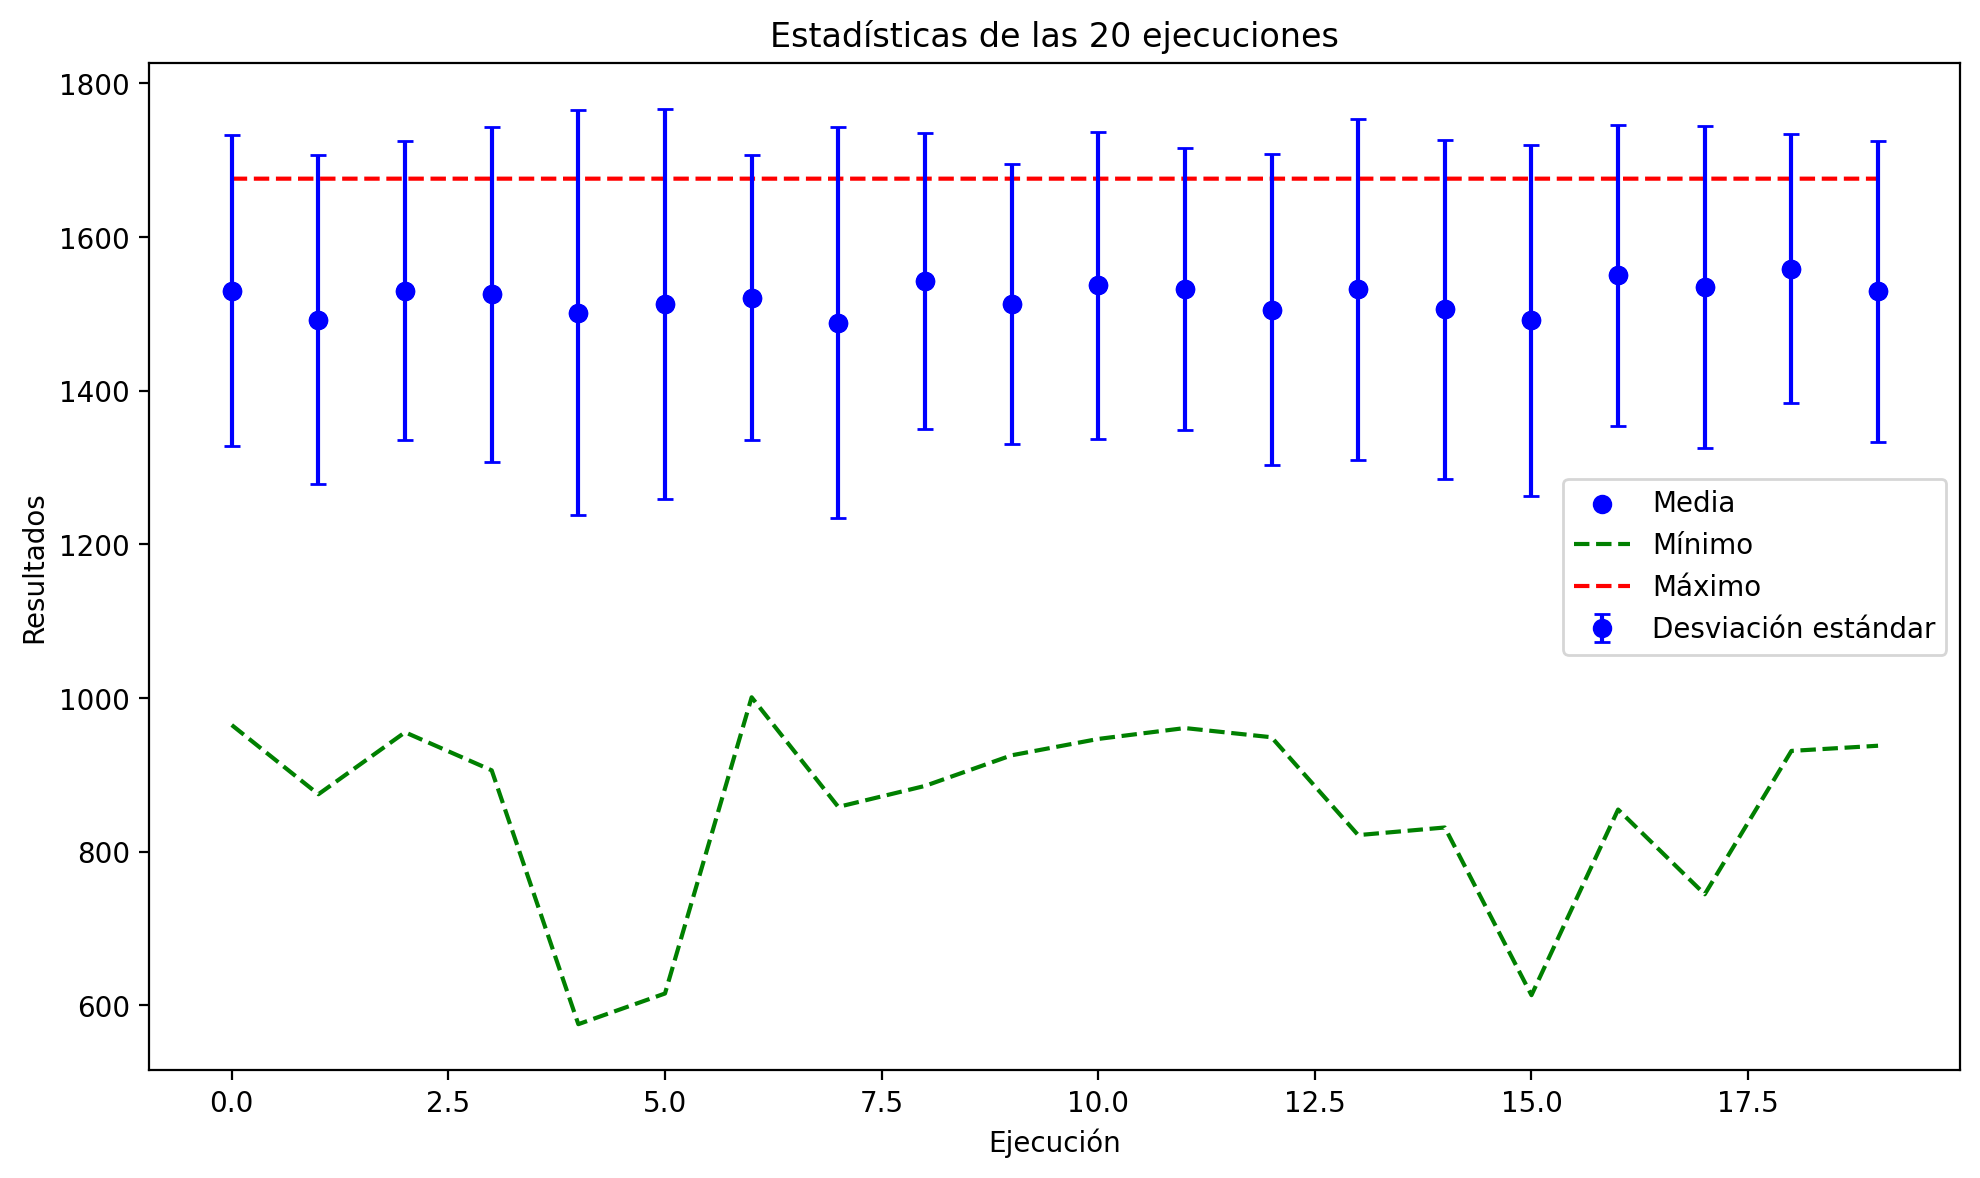

######## Resultados promediados ########
      Mínima: 857.7318361988088
      Media: 1521.7939129552365
      Máxima: 1675.9314153088187
      Desviación estándar: 209.6242826451766


In [156]:
# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar medias
plt.scatter(df_stats.index, df_stats['media_apt'], color='blue', label='Media')

# Graficar mínimos y máximos
plt.plot(df_stats.index, df_stats['min_apt'], linestyle='--', color='green', label='Mínimo')
plt.plot(df_stats.index, df_stats['max_apt'], linestyle='--', color='red', label='Máximo')

# Graficar desviación estándar como barras de error
plt.errorbar(df_stats.index, df_stats['media_apt'], yerr=df_stats['std_apt'], fmt='o', color='blue', capsize=3, label='Desviación estándar')

# Presentación
plt.xlabel('Ejecución')
plt.ylabel('Resultados')
plt.title('Estadísticas de las 20 ejecuciones')
plt.legend()
plt.tight_layout()
plt.show()

print(f'''######## Resultados promediados ########
      Mínima: {df_stats['min_apt'].mean()}
      Media: {df_stats['media_apt'].mean()}
      Máxima: {df_stats['max_apt'].mean()}
      Desviación estándar: {df_stats['std_apt'].mean()}''')


### Punto 3
Reportar gráfica de convergencia. Eje x número de generaciones, eje y mediana de la mejor aptitud de cada generación.

In [168]:
ejecuciones_max = pd.DataFrame()
for run in range(20):
    max_apts = pd.Series([log_generacion(f'gen_pop_run{run}_{n}', mode='load')['apt'].max() for n in range(num_gener)])
    ejecuciones_max[run] = max_apts

In [178]:
medianas = ejecuciones_max.median()

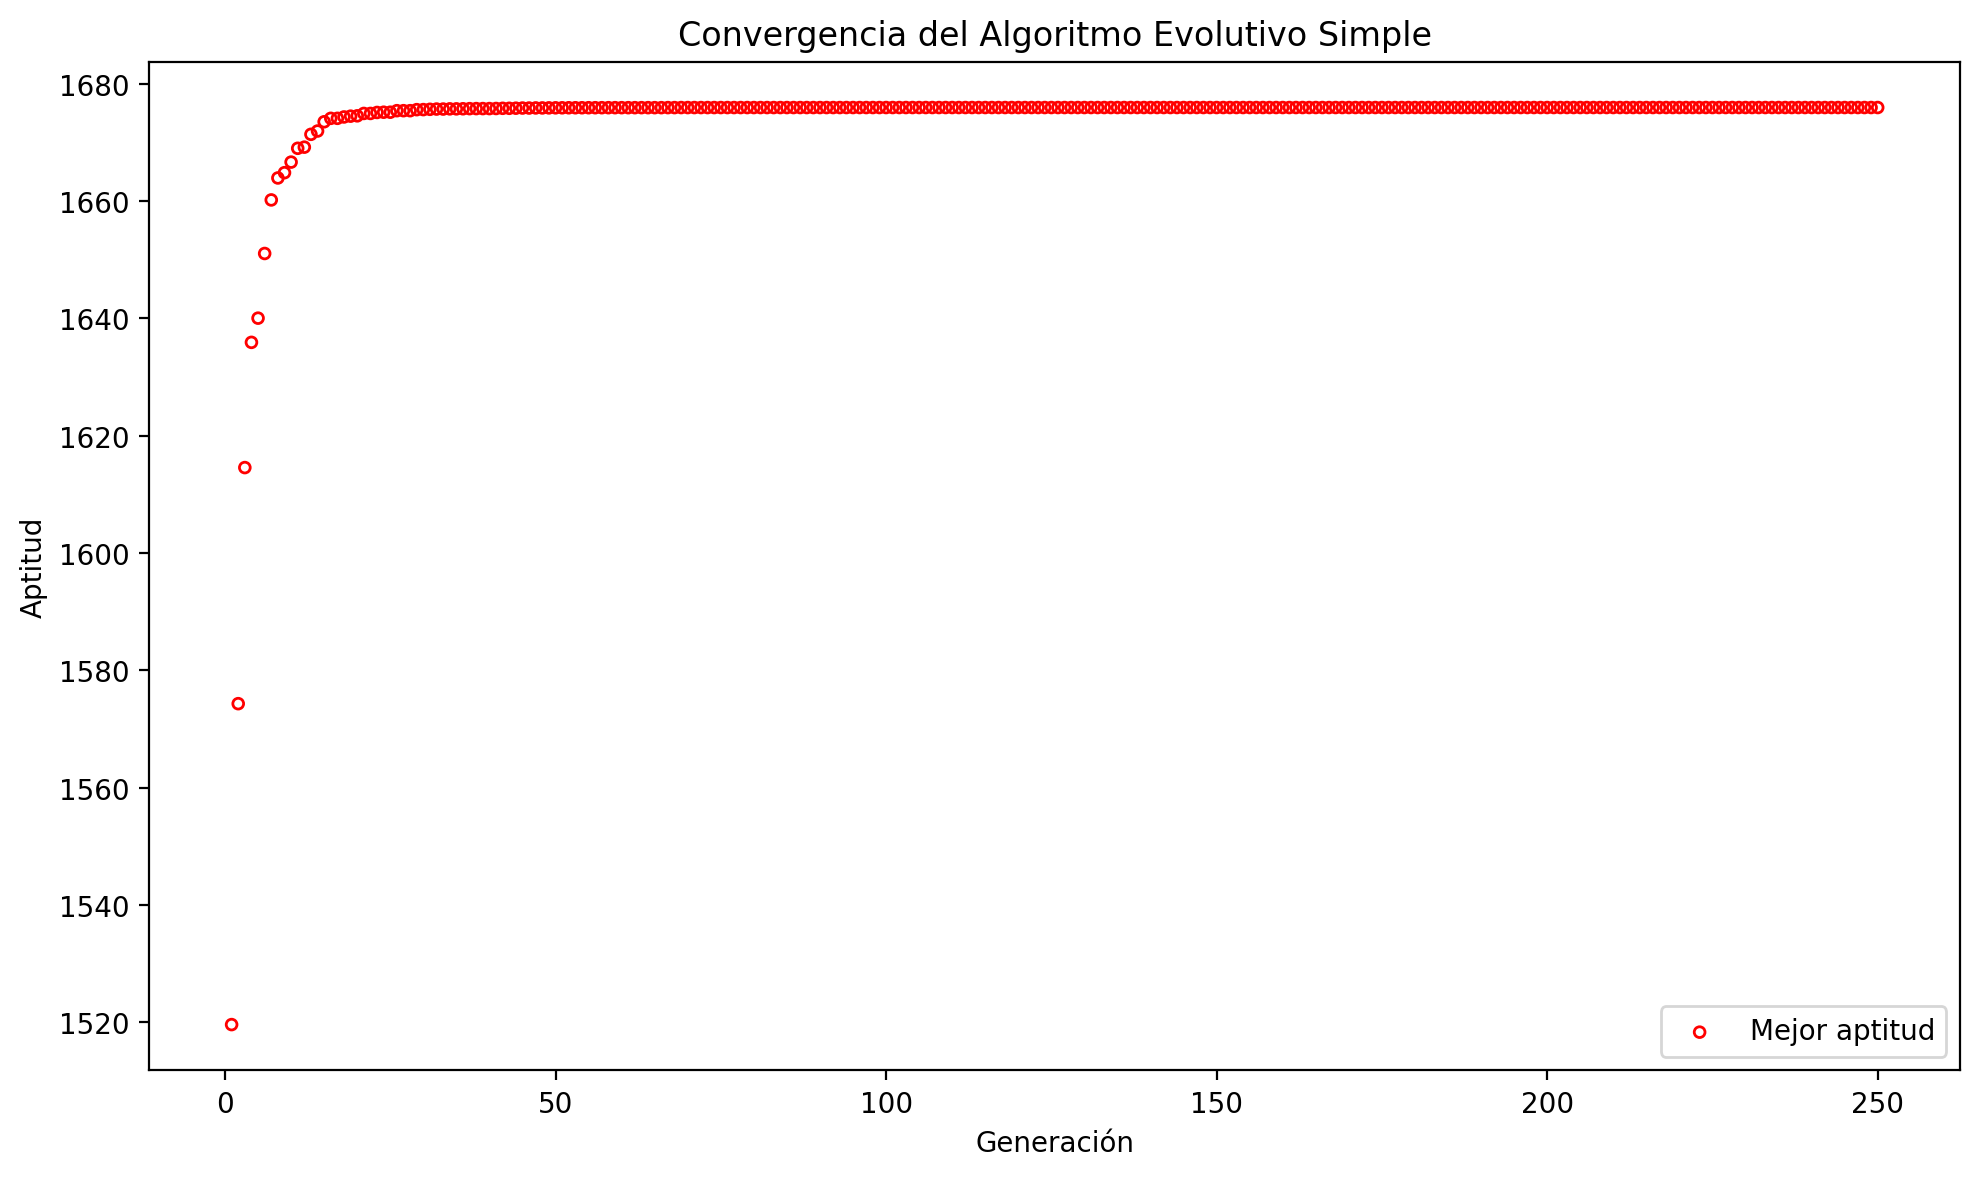

In [179]:
# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar medianas
plt.scatter(range(1,num_gener+1), medianas, label='Mejor aptitud', marker='o', facecolors='none', edgecolors='red', s=15)

# Presentación
plt.xlabel('Generación')
plt.ylabel('Aptitud')
plt.title('Convergencia del Algoritmo Evolutivo Simple')
plt.legend()
plt.tight_layout()
plt.show()


### Extra 4

PDF con los resultados de la ejecución mínima, resultados promediados, gráfica de convergencia y estimación de tamaño del
espacio de búsqueda

Una estimación del tamaño del espacio de búsqueda podría encontrarse mediante el cálculo de los valores enteros posibles en la representación de los genes en el cromosoma que cumplan con estar dentro del dominio del problema.

1. El dominio del problema consta de números reales dentro de $[-500,500]\times[-500,500]$.
2. Se escoge una `precision` para cada variable; es decir, el número de dígitos luego del punto decimal.
3. Se habrá realizado una transformación como la siguiente:
$$451.565481 \rightarrow 451565481$$
4. Esta representación de cada variable no adquirirá mayor precisión dentro del algoritmo. Por lo tanto, cada variable sólo podrá tomar valores enteros en $[-500\times 10^{\text{precision}}, 500\times 10^{\text{precision}}]$.
Esto es $n= 1000 \times 10^{\text{precision}}+1$. (El $+1$ es debido al cero del intervalo).
5. Ya que se tienen dos variables en el mismo intervalo, entonces:
$$|\text{Espacio de búsqueda}|\approx \left( 10^{3+\text{precision}}+1 \right)^2 $$
\end{enumerate}

Como nota adicional, la expresión binaria del cromosoma tendrá una cardinalidad mayor o igual que el dominio de nuestro problema por construcción, por lo que al momento de normalizar los límites enteros del dominio tal que $limsup \leftarrow 1...1$ y $liminf \leftarrow 0...0$, la función del espacio de expresiones binarias al espacio de enteros será suprayectiva.



